# 3.0 Implementing FCN-8 architecture

![alt text](https://drive.google.com/uc?id=1g7I0P5spyA5P2T7oucrEECf1Ie3VgL-b)

![alt text](https://drive.google.com/uc?id=1ywE_08nks3H7CAVEZHLCXUr4VeHuQKSO)

**References-**
- https://github.com/seth814/Semantic-Shapes
- https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html
- https://www.youtube.com/watch?v=-3ylPH3BCWY

In [0]:
def fcn_8(img_shape, base, dropout,n_classes):
    i = Input(shape=img_shape)
    b= base
    
    ## Block 1
    x = Conv2D(2**b, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block1_conv1')(i)
    x = BatchNormalization()(x)
    x = Conv2D(2**b, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = Dropout(dropout)(x)
    
    # Block 2
    x = Conv2D(2**(b+1), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+1), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = Dropout(dropout)(x)
    
    # Block 3
    x = Conv2D(2**(b+2), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+2), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+2), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(dropout)(x)
    pool3 = x
    
    # Block 4
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    pool4 = Dropout(dropout)(pool4)
    
    # Block 5
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block5_conv1')(pool4)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', kernel_initializer = 'he_normal', padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    pool5 = Dropout(dropout)(pool5)
    
    conv6 = Conv2D(2**(b+3)*8 , (7, 7) , activation='relu', kernel_initializer = 'he_normal' , padding='same', name="conv6")(pool5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2**(b+3)*8 , (1, 1) , activation='relu', kernel_initializer = 'he_normal' , padding='same', name="conv7")(conv6)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)
    
    pool4_n = Conv2D(n_classes, (1, 1), activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    u2 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7)
    u2_skip = Add()([pool4_n, u2])
    
    pool3_n = Conv2D(n_classes, (1, 1), activation='relu', padding='same')(pool3)
    u4 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(u2_skip)
    u4_skip = Add()([pool3_n, u4])
    
    output = Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), padding='same',activation='sigmoid')(u4_skip)
    
    model = Model(inputs=[i], outputs=[output])
    
    return model

In [0]:
#https://keras.io/models/model/#fit_generator
model= fcn_8(img_shape= (128,800,3), base= 4, dropout= 0.3, n_classes= 4)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 800, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128, 800, 16) 64          block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 800, 16) 2320        batch_normalization_16[0][0]     
____________________________________________________________________________________________

## 3.1 Checkpointing the model and creating the callback list

In [0]:
tbc=TensorBoardColab()
mc = ModelCheckpoint('best_model_fcn8.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [mc, TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
https://358ac569.ngrok.io


## 3.2 Fitting the train data and validation

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1, 
                              class_weight=class_wts, callbacks = callbacks_list)

ERROR! Session/line number was not unique in database. History logging moved to new session 60




Epoch 1/30
667/667 [==============================] - 262s 392ms/step - loss: 0.8073 - dice_coef: 0.2814 - val_loss: 0.7385 - val_dice_coef: 0.3199

Epoch 00001: val_dice_coef improved from -inf to 0.31990, saving model to best_model.h5

Epoch 2/30
667/667 [==============================] - 236s 354ms/step - loss: 0.6018 - dice_coef: 0.4443 - val_loss: 0.7356 - val_dice_coef: 0.3235

Epoch 00002: val_dice_coef improved from 0.31990 to 0.32351, saving model to best_model.h5
Epoch 3/30
667/667 [==============================] - 238s 357ms/step - loss: 0.5655 - dice_coef: 0.4768 - val_loss: 0.6561 - val_dice_coef: 0.3929

Epoch 00003: val_dice_coef improved from 0.32351 to 0.39290, saving model to best_model.h5
Epoch 4/30
667/667 [==============================] - 239s 358ms/step - loss: 0.5419 - dice_coef: 0.4991 - val_loss: 0.5570 - val_dice_coef: 0.4868

Epoch 00004: val_dice_coef improve

In [0]:
#round 2 for 20 epochs
model= model_best
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
class_wts= [1.98,7.18,0.34,2.21]
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1,
                              class_weight=class_wts, callbacks = callbacks_list)



Epoch 1/20
667/667 [==============================] - 260s 389ms/step - loss: 0.5078 - dice_coef: 0.5295 - val_loss: 0.5507 - val_dice_coef: 0.5024

Epoch 00001: val_dice_coef improved from -inf to 0.50236, saving model to best_model.h5

Epoch 2/20
667/667 [==============================] - 244s 366ms/step - loss: 0.5027 - dice_coef: 0.5344 - val_loss: 0.5386 - val_dice_coef: 0.5093

Epoch 00002: val_dice_coef improved from 0.50236 to 0.50929, saving model to best_model.h5
Epoch 3/20
667/667 [==============================] - 251s 376ms/step - loss: 0.4952 - dice_coef: 0.5414 - val_loss: 0.5888 - val_dice_coef: 0.4639

Epoch 00003: val_dice_coef did not improve from 0.50929
Epoch 4/20
667/667 [==============================] - 249s 374ms/step - loss: 0.4775 - dice_coef: 0.5588 - val_loss: 0.5142 - val_dice_coef: 0.5323

Epoch 00004: val_dice_coef improved from 0.50929 to 0.53226, saving model to best_model.h5
Epoch 5/20
667/667 [==============================] - 241s 362ms/step - los

## 3.3 Plots on training & validation results

### Loss function & metric plots

**Please refer to Training Plots in utility functions section.**

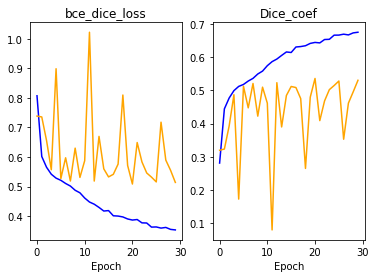

In [0]:
#first 30 epochs
plot(history)

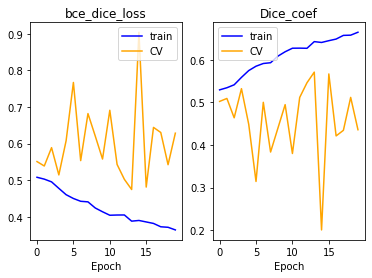

In [0]:
#next 20 epochs
plot(history)

### Tensorboard images

![alt text](https://drive.google.com/uc?id=1o3Hs72Xzl7PdDKKbrqMDCKVDt3uwG7Q-)

![alt text](https://drive.google.com/uc?id=1wKQ-ODvDQ6OjeVKjEFwg1P0Zs89Vo0DK)

![alt text](https://drive.google.com/uc?id=13G4T-Z31nuttI7oGn1D6g5QPuT-lMj2h)

## 3.4 Model Testing

### Loading the best model for evaluation

** Considering the best model which was trained on 30 epochs as the model in the next 20 epochs experienced the problem of overfitting.**

In [0]:
from keras.models import load_model
dependencies = {'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef,}
model_best = load_model('/content/best_model_fcn8.h5',custom_objects=dependencies)

### Evaluating on validation images

In [0]:
evals1= model_best.evaluate(valid_batches,verbose=1)

117/117 [==============================] - 33s 282ms/step


In [0]:
print('Validation set evaluation score:')
print('bce_dice loss:',evals1[0])
print('dice_coeff:',evals1[1])

Validation set evaluation score:
bce_dice loss: 0.5122087106236026
dice_coeff: 0.531455701447896


## 3.5 Defects visualization

**Please refer to the "visualize_defects" function in Utility functions section.**

### Training set

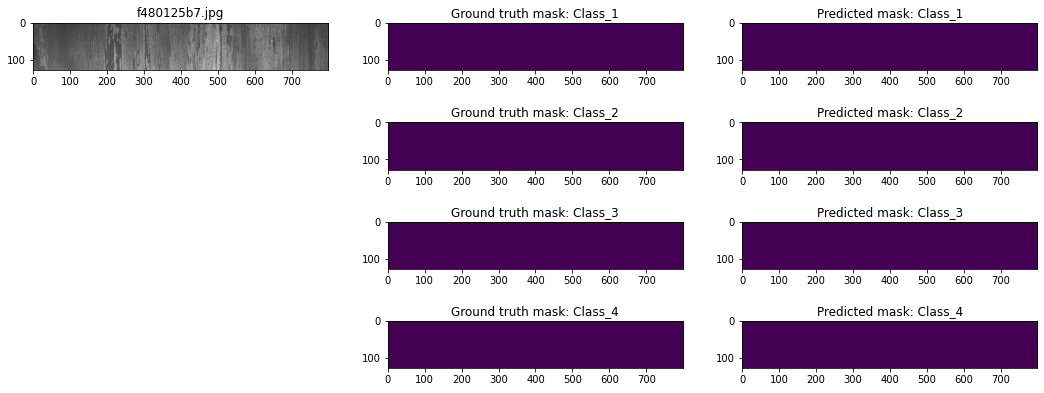

------------------------------------------------------------------------------------------------------------------------------------------------------


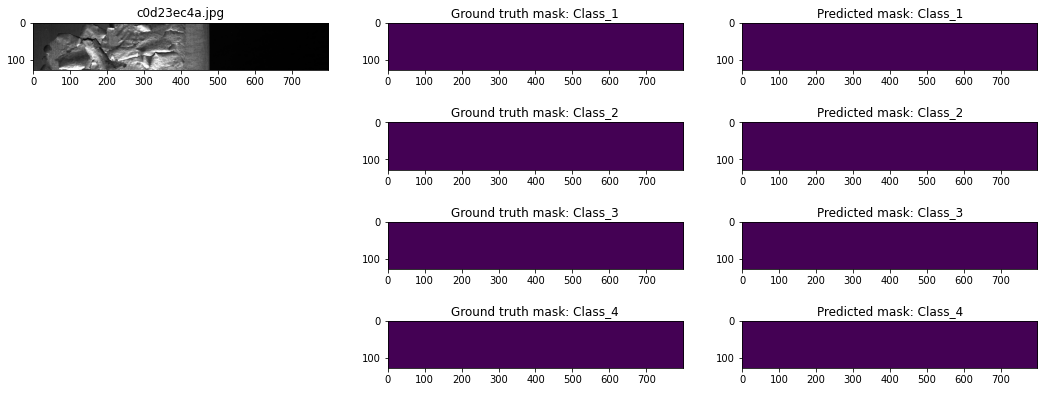

------------------------------------------------------------------------------------------------------------------------------------------------------


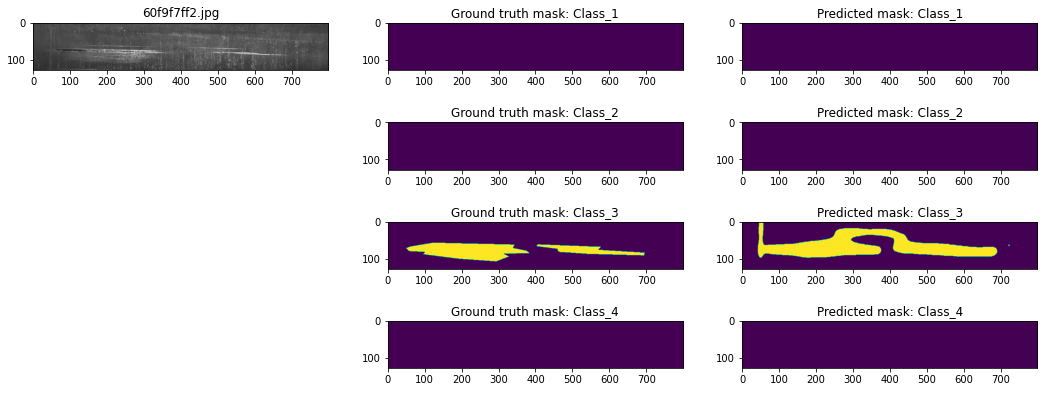

------------------------------------------------------------------------------------------------------------------------------------------------------


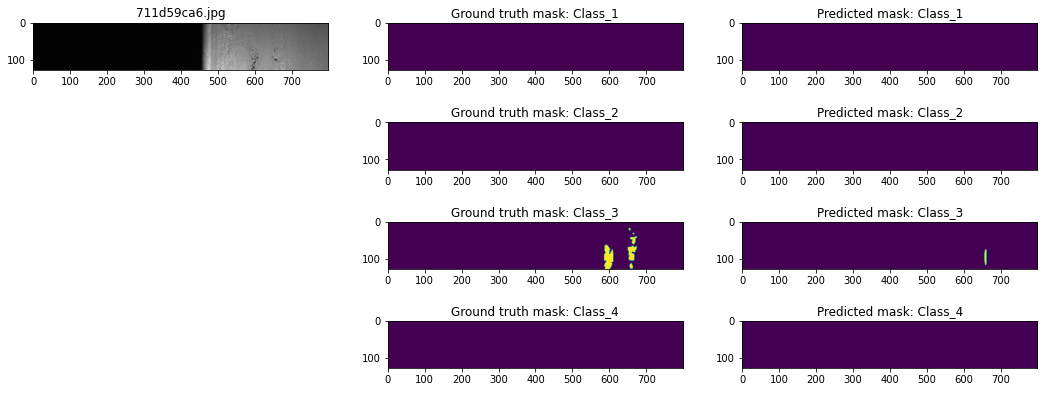

------------------------------------------------------------------------------------------------------------------------------------------------------


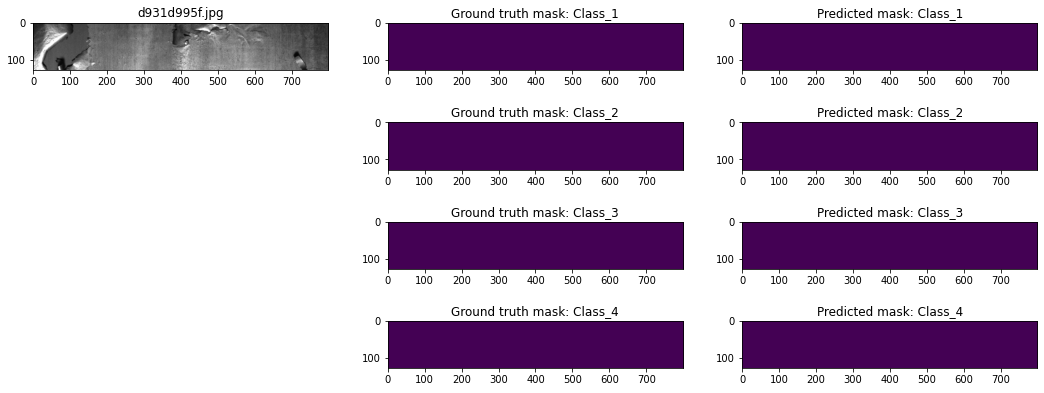

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

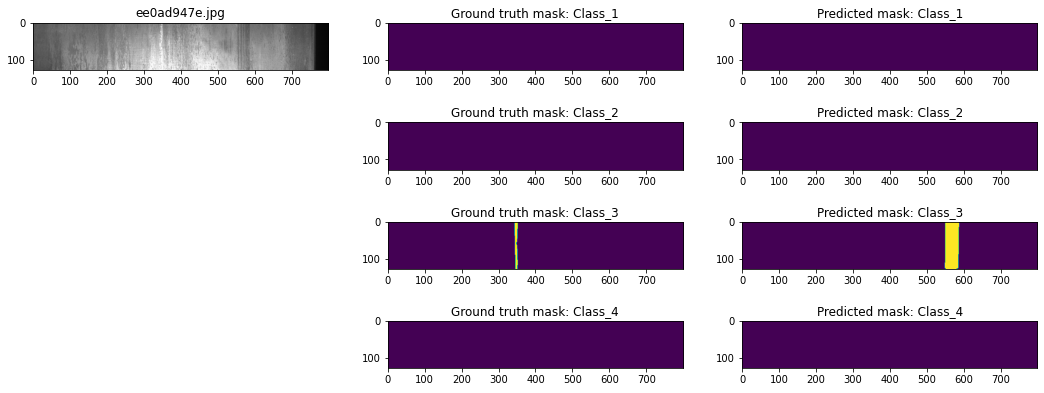

------------------------------------------------------------------------------------------------------------------------------------------------------


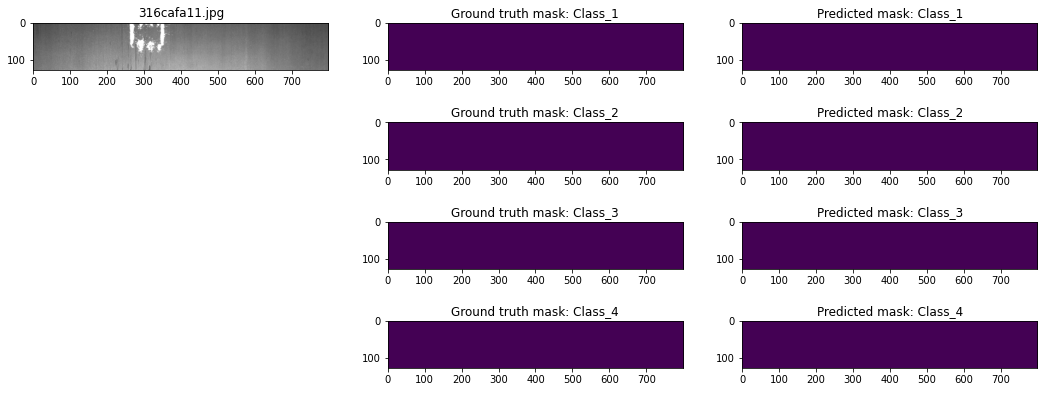

------------------------------------------------------------------------------------------------------------------------------------------------------


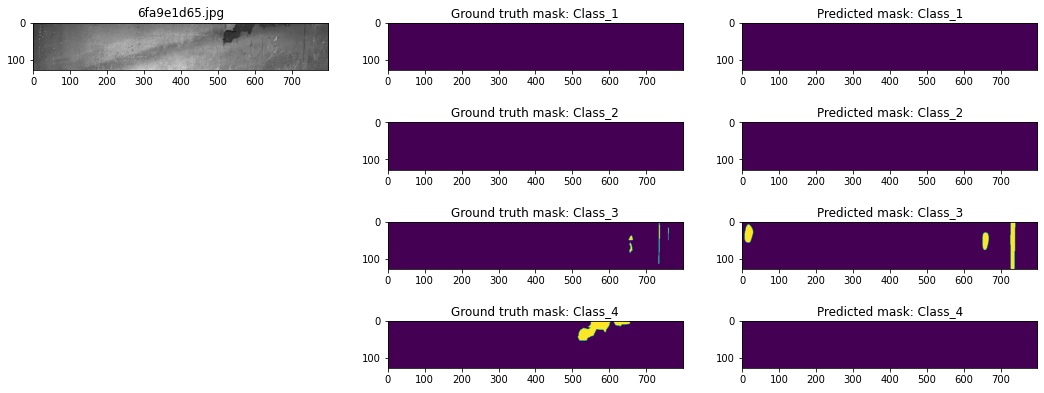

------------------------------------------------------------------------------------------------------------------------------------------------------


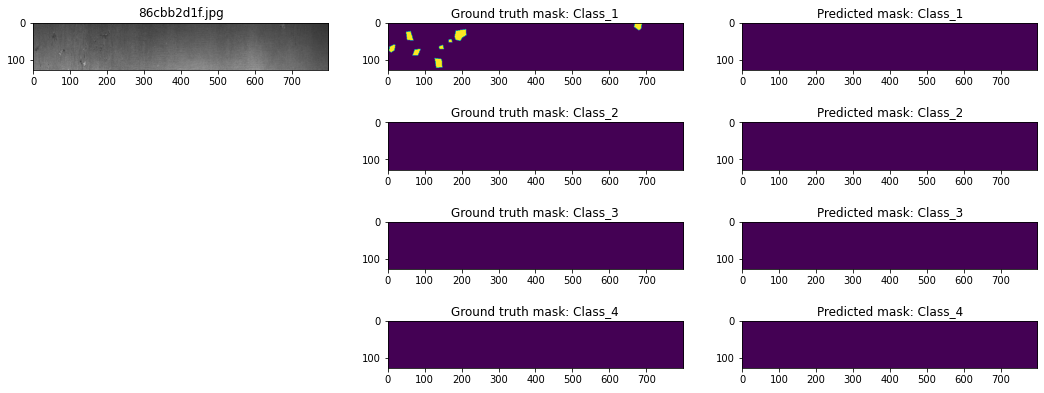

------------------------------------------------------------------------------------------------------------------------------------------------------


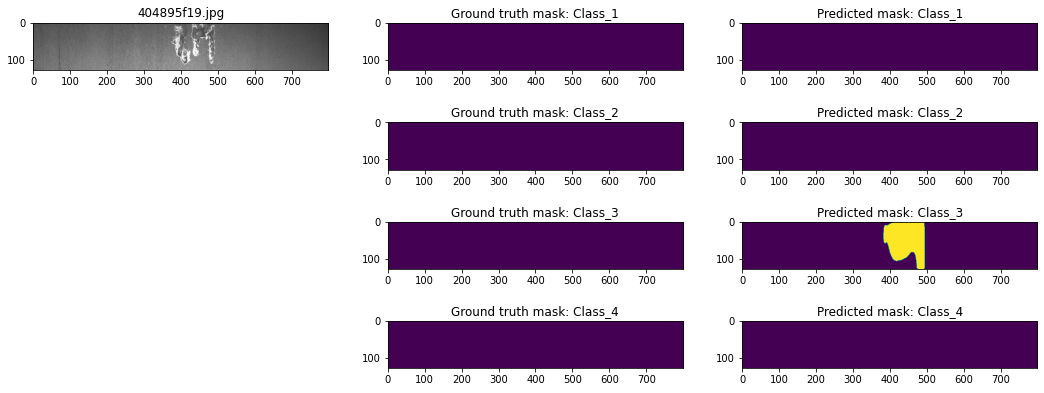

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

### Validation set

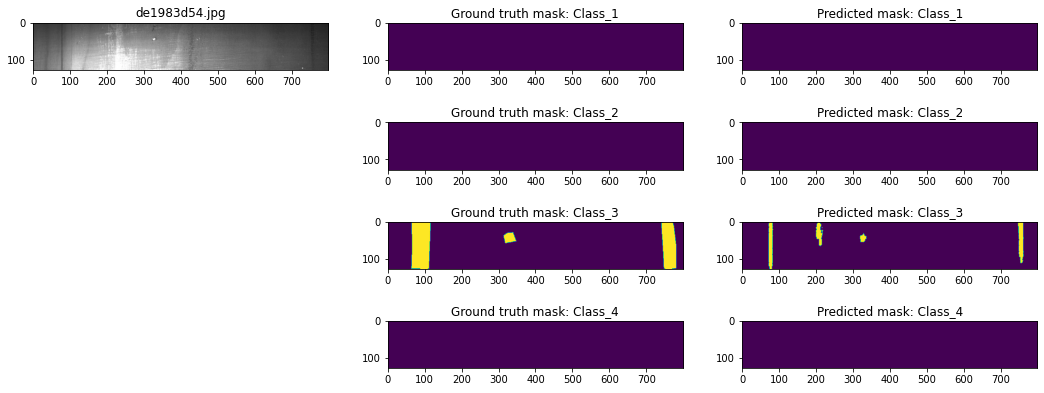

------------------------------------------------------------------------------------------------------------------------------------------------------


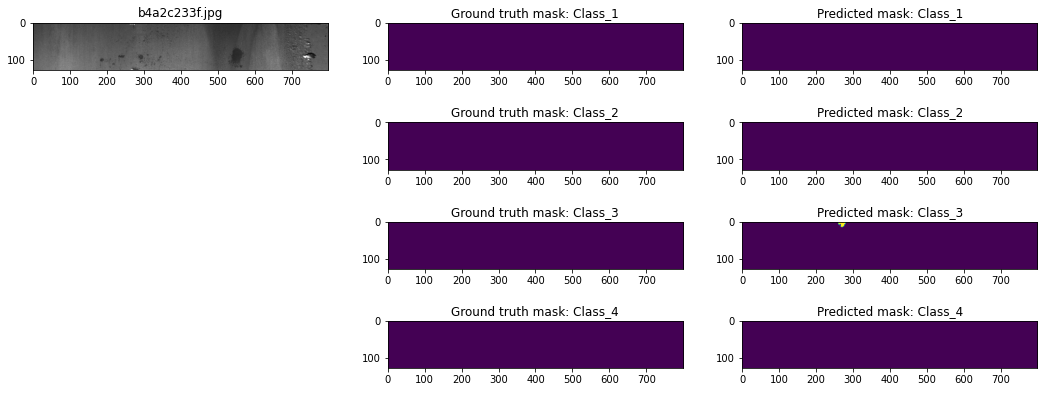

------------------------------------------------------------------------------------------------------------------------------------------------------


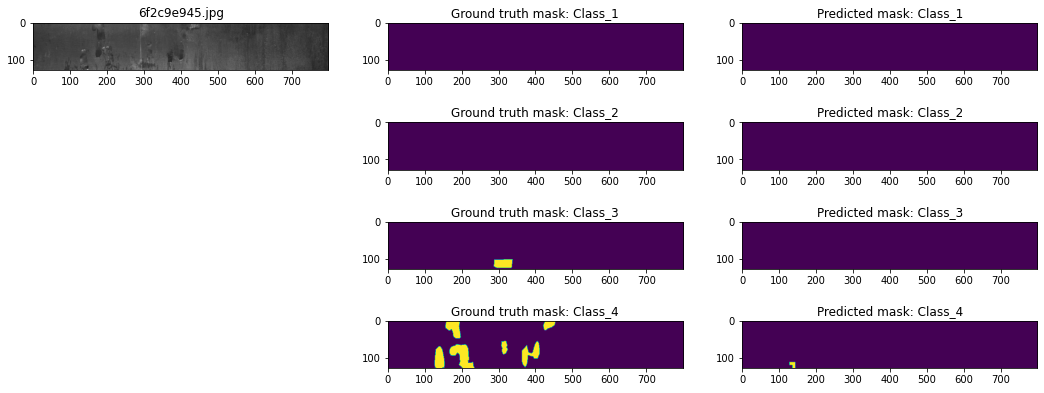

------------------------------------------------------------------------------------------------------------------------------------------------------


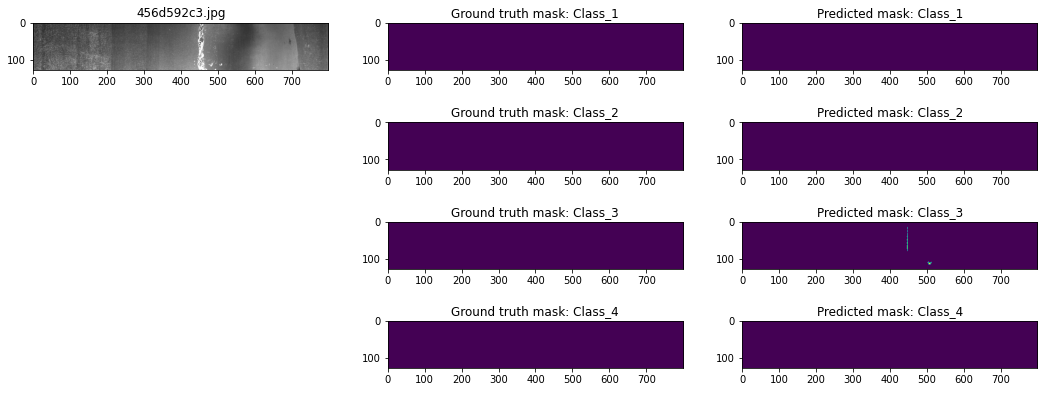

------------------------------------------------------------------------------------------------------------------------------------------------------


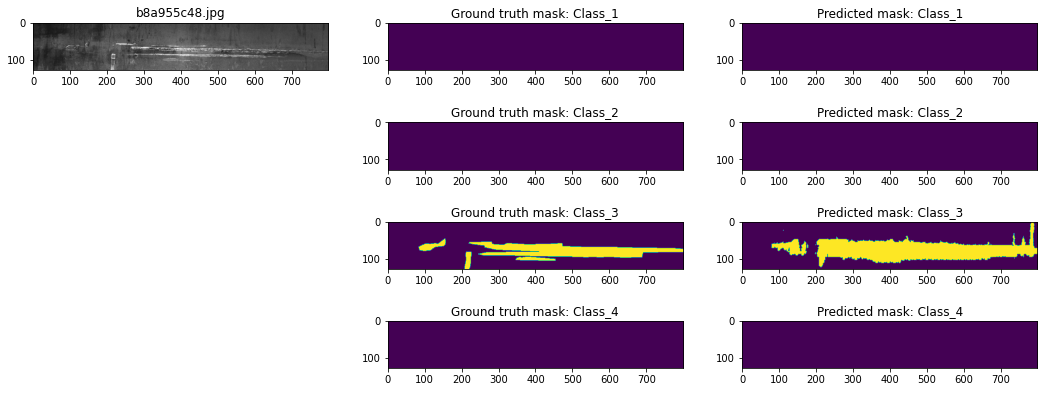

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

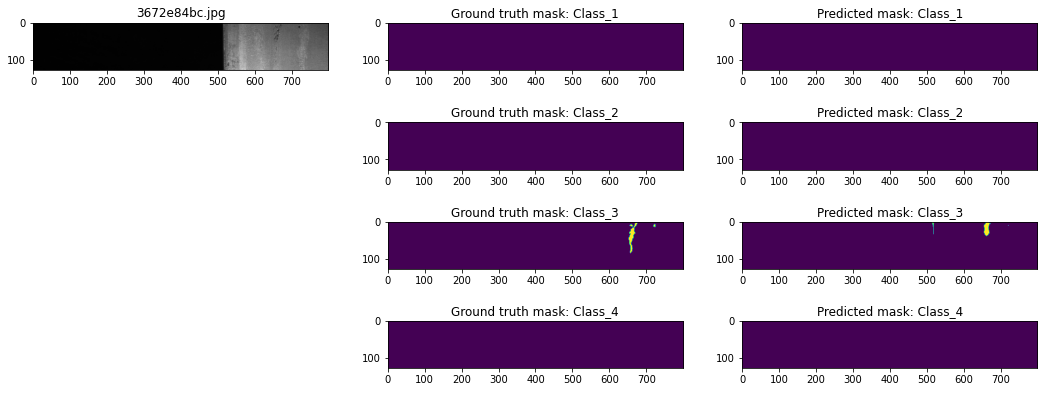

----------------------------------------------------------------------------------------------------


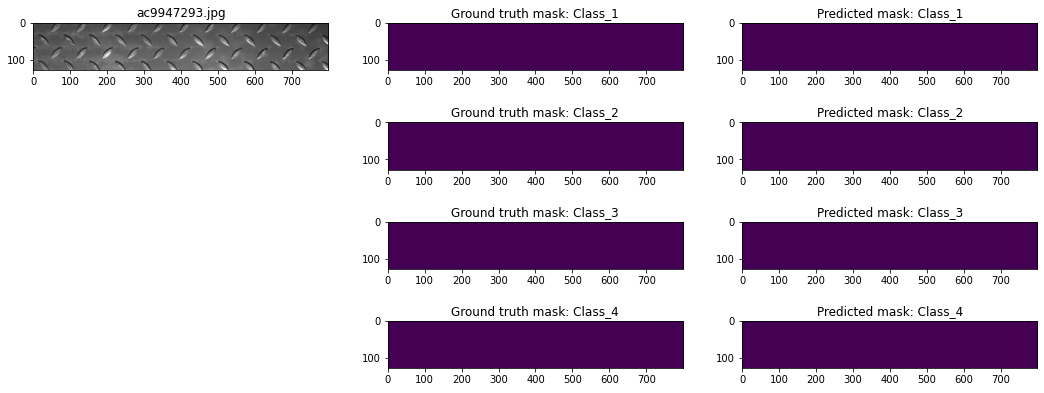

----------------------------------------------------------------------------------------------------


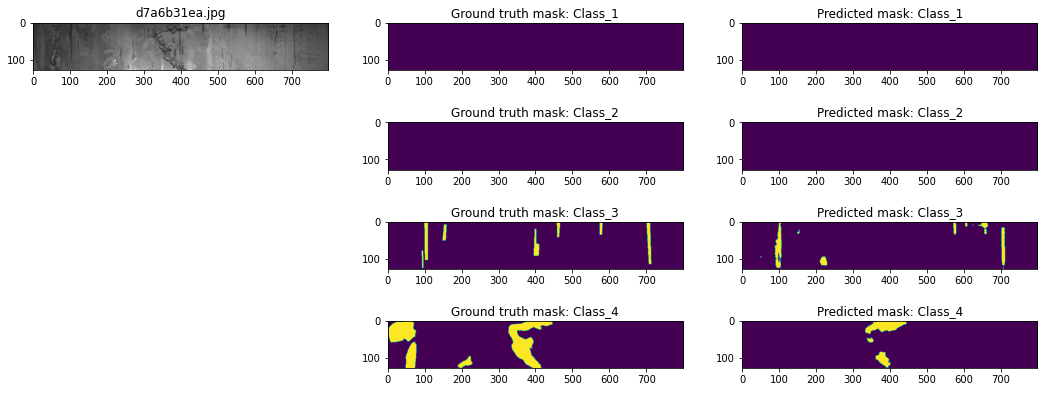

----------------------------------------------------------------------------------------------------


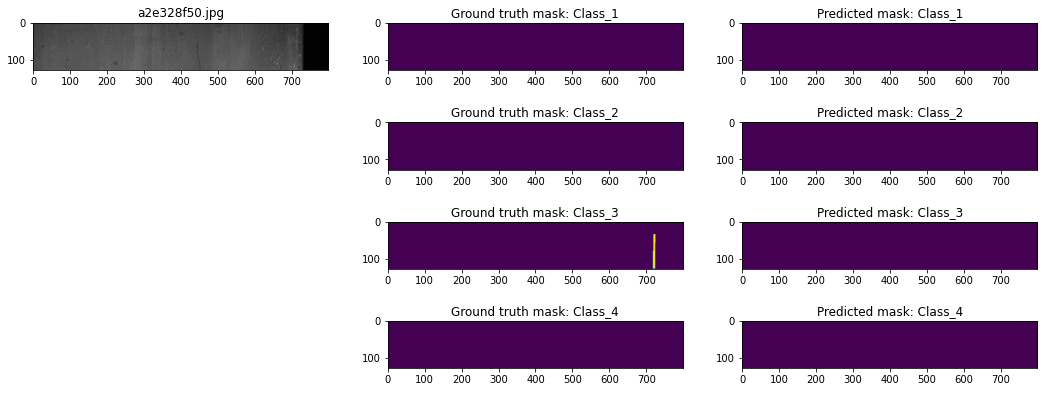

----------------------------------------------------------------------------------------------------


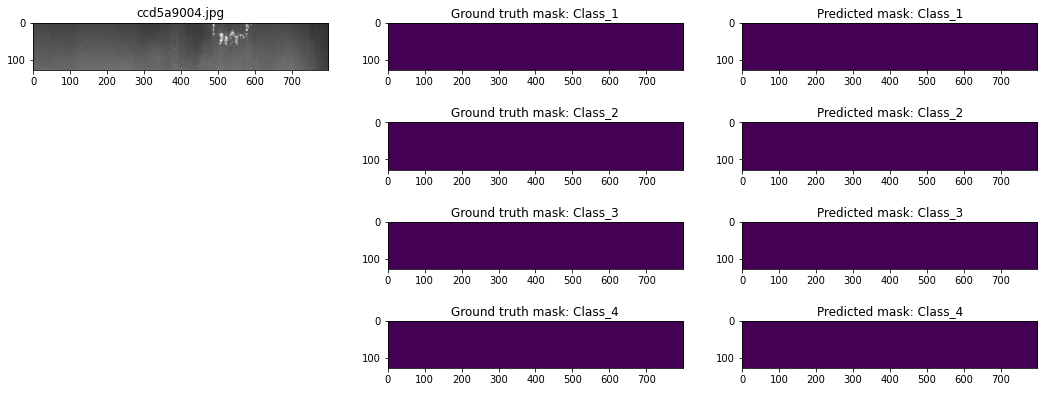

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

## 3.6 Predicting defects on raw test images

### Redefining the FCN8 architecture for original image size of 256x1600

In [0]:
#https://keras.io/models/model/#fit_generator
model= fcn_8(img_shape= (256,1600,3), base= 4, dropout= 0.3, n_classes= 4)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 1600, 16 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 256, 1600, 16 64          block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 1600, 16 2320        batch_normalization_61[0][0]     
____________________________________________________________________________________________

In [0]:
model.set_weights(model_best.get_weights())

### Predicting on full 256x1600 raw test images

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId

for f in tqdm(files):
    X = np.empty((1,256,1600,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[0,] = img
    mask = model.predict(X)
    rle_m = np.empty((256,1600),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [05:48<00:00, 15.82it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission_fcn8_256x1600.csv', index=False)

**With this submission, I got a private dice coefficient score of 0.82818 & a public score of 0.84935.**

## 3.7 Visualizing defects of raw test images(256x1600)

**Please refer to the "visualize_defects_test" function in Utility functions section.**

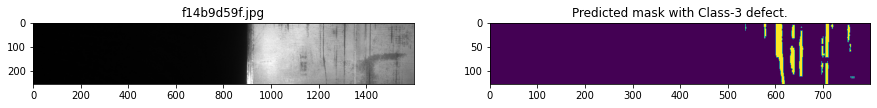

------------------------------------------------------------------------------------------------------------------------------------------------------


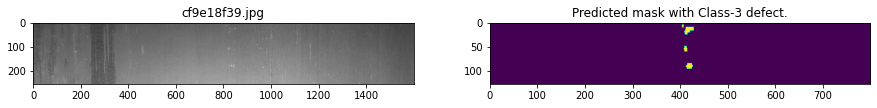

------------------------------------------------------------------------------------------------------------------------------------------------------


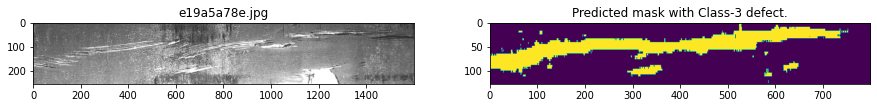

------------------------------------------------------------------------------------------------------------------------------------------------------


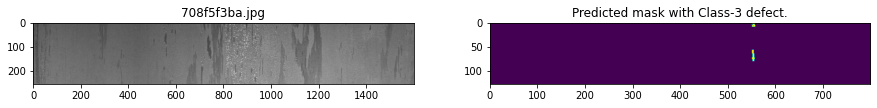

------------------------------------------------------------------------------------------------------------------------------------------------------


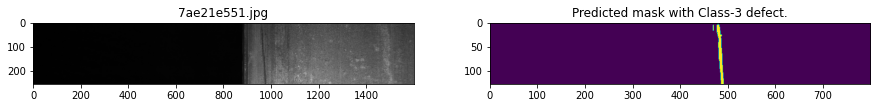

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

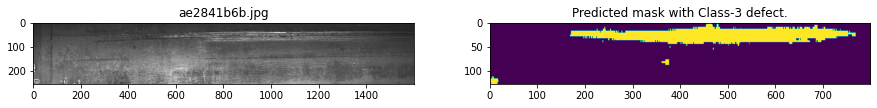

------------------------------------------------------------------------------------------------------------------------------------------------------


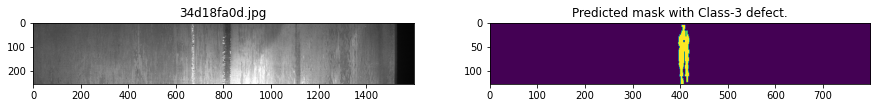

------------------------------------------------------------------------------------------------------------------------------------------------------


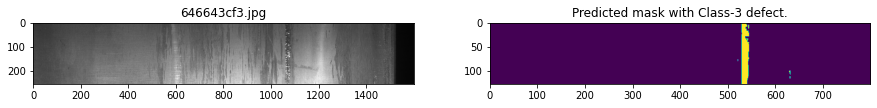

------------------------------------------------------------------------------------------------------------------------------------------------------


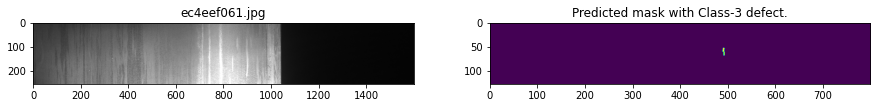

------------------------------------------------------------------------------------------------------------------------------------------------------


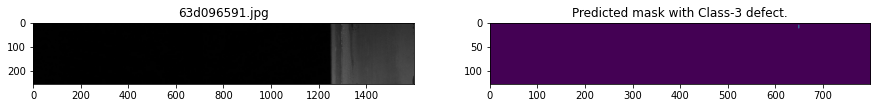

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

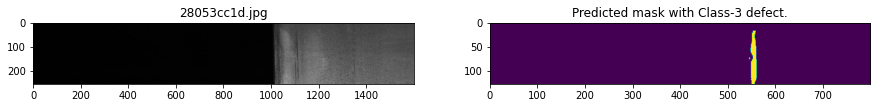

------------------------------------------------------------------------------------------------------------------------------------------------------


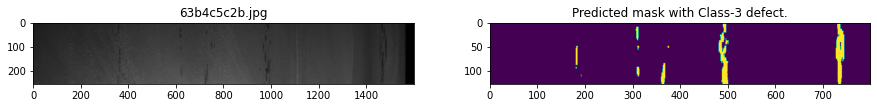

------------------------------------------------------------------------------------------------------------------------------------------------------


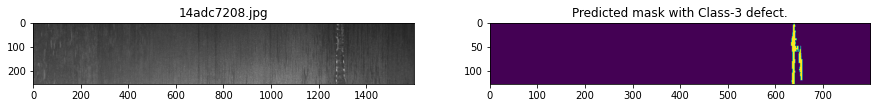

------------------------------------------------------------------------------------------------------------------------------------------------------


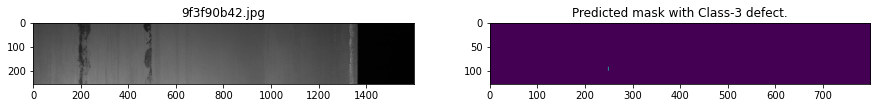

------------------------------------------------------------------------------------------------------------------------------------------------------


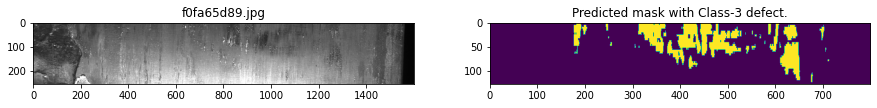

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)